In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install -q SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 37.5 MB/s eta 0:00:00


In [11]:
#impport library
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import  gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [13]:
#package tokenizer
nltk.download('punkt')
#package Lemmatization
nltk.download('wordnet')
#package multigual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
# Importing the dataset
with open('/content/drive/MyDrive/Dataset/anotasi/kb.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [16]:
data.head()

,patterns,tags
0,hello,greeting
1,hai,greeting
2,helo,greeting
3,hi,greeting
4,hy,greeting


In [17]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

In [19]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

9 unique lemmatized words ['apa', 'hai', 'hello', 'helo', 'hi', 'hy', 'itu', 'panbot', 'siapa']


In [20]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

2 classes ['greeting', 'panbot']


In [21]:
# documents = combination between patterns and intents
print (len(documents), "documents")

29 documents


In [22]:

# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[2], [3], [4], [5], [6], [7, 8, 1], [9, 1]]

In [23]:
# Apply padding 
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[0 0 2]
 [0 0 3]
 [0 0 4]
 [0 0 5]
 [0 0 6]
 [7 8 1]
 [0 9 1]]


In [24]:
# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train) #Label Encodings

[0 0 0 0 0 1 1]


In [25]:

# input length
input_shape = x_train.shape[1]
print(input_shape)

3


In [26]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  9
output length:  2


In [32]:

pickle.dump(words, open('/content/drive/MyDrive/Dataset/model/words.pkl','wb'))
pickle.dump(classes, open('/content/drive/MyDrive/Dataset/model/classes.pkl','wb'))

In [33]:
pickle.dump(le, open('/content/drive/MyDrive/Dataset/model/le.pkl','wb'))
pickle.dump(tokenizer, open('/content/drive/MyDrive/Dataset/model/tokenizers.pkl','wb'))


Neural Network Model

In [34]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])


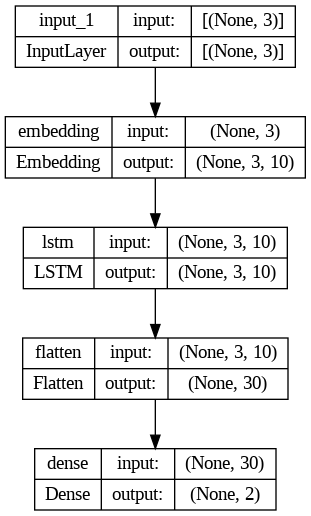

In [35]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/content/model_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 embedding (Embedding)       (None, 3, 10)             100       
                                                                 
 lstm (LSTM)                 (None, 3, 10)             840       
                                                                 
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 2)                 62        
                                                                 
Total params: 1,002
Trainable params: 1,002
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Training the model (Latih model data sampai 300 kali)
train = model.fit(x_train, y_train, epochs=300)

Epoch 1/300
1/1 [==============================] - 0s 21ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 2/300
1/1 [==============================] - 0s 18ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 3/300
1/1 [==============================] - 0s 19ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 4/300
1/1 [==============================] - 0s 15ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 5/300
1/1 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 6/300
1/1 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 7/300
1/1 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 8/300
1/1 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 9/300
1/1 [==============================] - 0s 14ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 10/300
1/1 [==============================] - 0s 18ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 11/300
1/1 [=

Model Analyst

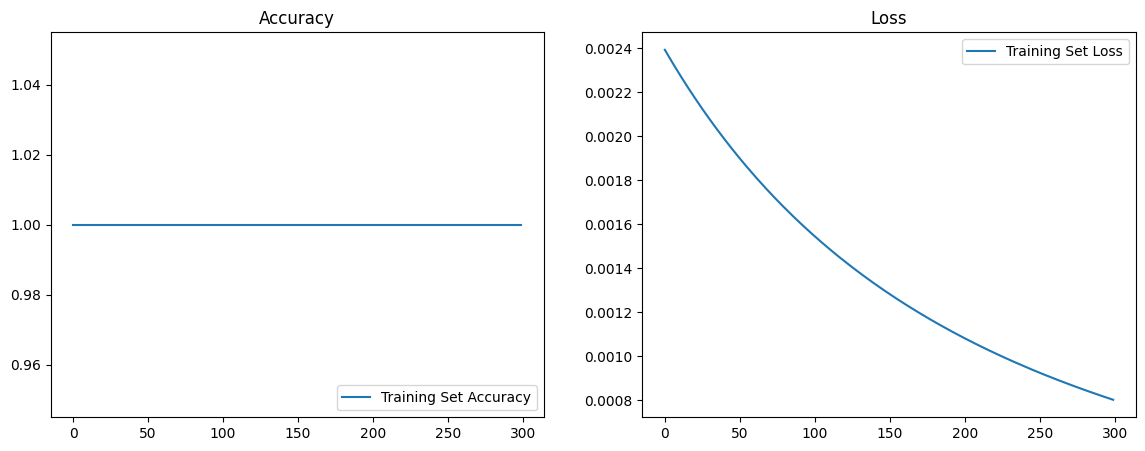

In [42]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Testing chatbot

In [46]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 PanBot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
  tts.save('/content/drive/MyDrive/Dataset/model/KadekBot.wav')
  time.sleep(0.08)
  # Load model voice bot from Google Drive
  ipd.display(ipd.Audio('/content/drive/MyDrive/Dataset/model/KadekBot.wav', autoplay=False))
  print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

👨‍🦰 Kamu : hy
1/1 [==============================] - 0s 35ms/step
🤖 PanBot :  Hallo Panbot datang, apa kabarmu hari ini ?



👨‍🦰 Kamu : googbye
1/1 [==============================] - 0s 25ms/step
🤖 PanBot :  Hai! Panbot disini , mau tanya  tentang apa nih ?



👨‍🦰 Kamu : goodbye
1/1 [==============================] - 0s 55ms/step
🤖 PanBot :  Hallo Panbot datang, apa kabarmu hari ini ?



👨‍🦰 Kamu : google itu apa 
1/1 [==============================] - 0s 25ms/step
🤖 PanBot :  panbot adalah platfrom chatbot untuk meminta informasi



👨‍🦰 Kamu : bye
1/1 [==============================] - 0s 25ms/step
🤖 PanBot :  Hallo Panbot datang, apa kabarmu hari ini ?



👨‍🦰 Kamu : goodbye
1/1 [==============================] - 0s 26ms/step
🤖 PanBot :  Hai! Panbot disini , mau tanya  tentang apa nih ?


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-46-171dfbbc1c3b>", line 4, in <cell line: 2>
    prediction_input = input('👨‍🦰 Kamu : ')
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 851, in raw_input
    return self._input_request(str(prompt),
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 895, in _input_request
    raise KeyboardInterrupt("Interrupted by user") from None
KeyboardInterrupt: Interrupted by user

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling

TypeError: ignored

In [ ]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('chat_model.h5')

print('Model Created Successfully!')